In [1]:
import numpy as np
import pandas as pd
import os

In [2]:
arbor_path = "arbor_connectome.csv"
arbor_table = pd.read_csv(arbor_path)

In [3]:
celltype_all_path = "/Users/krystal/Desktop/project/TableS6_Full_morphometry_1222.xlsx"
celltype_all_table = pd.read_excel(celltype_all_path)

In [4]:
### filter
del_namelist_arbor = set(arbor_table['Unnamed: 0']).difference(celltype_all_table['Morphology Name'])
del_rows = arbor_table[arbor_table['Unnamed: 0'].isin(del_namelist_arbor)].index.tolist()
del_columns = list(arbor_table[arbor_table['Unnamed: 0'].isin(del_namelist_arbor)]['Unnamed: 0'])
arbor_table_del = arbor_table.drop(del_columns,axis=1)
arbor_table_del = arbor_table_del.drop(del_rows,axis=0)
arbor_table_del = arbor_table_del.reset_index(drop=True)

In [5]:
arbor_table_del.shape

(1873, 1874)

In [6]:
celltype_all = celltype_all_table[['Soma region','Cortical Lamination of soma']].fillna('').agg(''.join,axis=1)

In [7]:
arbor_namelist = list(arbor_table_del['Unnamed: 0'])

In [8]:
arbor_table2 = arbor_table_del.copy()
for c in arbor_table2.columns[1:]:
    arbor_table2[c] = arbor_table2[c].astype(float)

In [9]:
arbor_table3 = arbor_table2.drop(['Unnamed: 0'],axis=1)
arbor_table_mask = arbor_table3 < 0
arbor_table3[arbor_table_mask] = 0

In [11]:
arbor_table3.shape

(1873, 1873)

In [10]:
celltype_arbor = []
for i in range(len(arbor_table2)):
    name = arbor_namelist[i]
    row_id = celltype_all_table[celltype_all_table['Morphology Name']==name].index[0]
    celltype_arbor.append(celltype_all[row_id])

In [12]:
cp_namelist = list(celltype_all_table[celltype_all_table['Soma region']=='CP']['Morphology Name'])

In [13]:
arbor_table_array =  np.array(arbor_table3)

In [14]:
# input & output
cp_table = arbor_table_array[arbor_table_del[arbor_table_del['Unnamed: 0'].isin(cp_namelist)].index.tolist(),:]
# cp_trans_table = pd.DataFrame(cp_table.T)
# cp_trans_table['type'] = celltype_arbor
# cp_trans_sum = cp_trans_table.groupby(['type']).sum()
# cp_out_regions = cp_trans_sum.index
# cp_table_trans = np.array(cp_trans_sum)
# cp_out = cp_table_trans.T

In [15]:
cp_table.shape

(324, 1873)

In [16]:
names = np.array(arbor_table_del['Unnamed: 0'])[arbor_table_del[arbor_table_del['Unnamed: 0'].isin(cp_namelist)].index.tolist()]

In [17]:
### log
# cp_out_log = cp_out.copy()
# cp_out_log_mask = cp_out > 0
# cp_out_log[cp_out_log_mask] = np.log(cp_out_log[cp_out_log_mask])
cp_table2 = cp_table + 1
cp_log = np.log(cp_table2)

In [177]:
cp_log.shape

(388, 1873)

In [19]:
## spectral clustering, partition
from sklearn.cluster import SpectralClustering
from matplotlib import pyplot as plt
import networkx as nx
from sklearn.metrics import pairwise_distances
from sklearn import metrics

In [28]:
from scipy.spatial.distance import cdist
D = cdist(cp_log,cp_log,'euclidean')

In [98]:
s_scores = []
c_scores = []
# CH = 0
# gamma_best = 0
# k_cluster_best = 0
# for index, gamma in enumerate((1,1.5,2,2.5,5)):
#     for index,k in enumerate(np.arange(2,20)):
#         y_pred = SpectralClustering(n_clusters=k,gamma=gamma).fit_predict(cp_log)
#         curr_c = metrics.calinski_harabasz_score(cp_log,y_pred)
#         if curr_c > CH:
#             CH = curr_c
#             k_cluster_best = k
#             gamma_best = gamma

for i in range(2,20):
    cluster_i = SpectralClustering(n_clusters=i,affinity='rbf',n_neighbors=10,gamma=1.0,random_state=1024).fit(cp_log)
    # cluster_i = SpectralClustering(n_clusters=i,affinity='precomputed',eigen_solver='arpack',random_state=1024).fit(D)
    labels = cluster_i.labels_
    s_scores.append(metrics.silhouette_score(D,labels))
    c_scores.append(metrics.calinski_harabasz_score(D,labels))

In [99]:
np.argmax(s_scores),np.argmax(c_scores)

(0, 0)

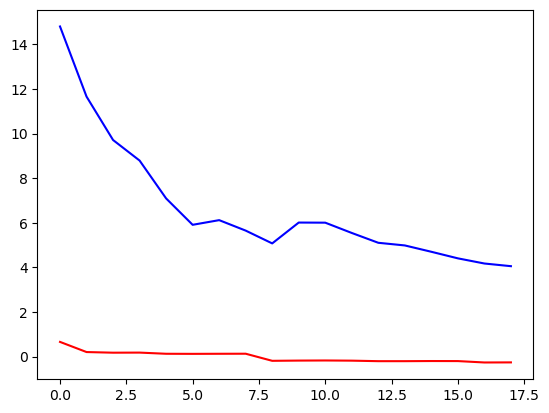

In [100]:
plt.plot(s_scores,c='red')
plt.plot(c_scores,c='blue')

In [153]:
cluster_sp = SpectralClustering(n_clusters=2,affinity='rbf',n_neighbors=10,gamma=1.0,random_state=1024).fit(cp_log)
L = cluster_sp.labels_

### compare

In [18]:
import sys
sys.path.append("/Users/krystal/Desktop/project/pylib-main")
from file_io import load_image, save_image
from anatomy.anatomy_config import MASK_CCF25_FILE, MASK_CCF25_R314_FILE, REGION314, REGION671, SALIENT_REGIONS

In [19]:
mask_file = MASK_CCF25_FILE
mask = load_image(mask_file)
cp_parc = mask.copy()
cp_parc.fill(0)
cur_id = 0
idlist = [1072,1079,1088]
for i in idlist:
    path = '/Users/krystal/Desktop/project/Brain_test/BrainParcellation/microenviron/Tmp/parc_region'+str(i)+'.nrrd'
    f = load_image(path)
    nzm = f != 0
    cp_parc[nzm] = f[nzm] + cur_id
    cur_id += f.max()

In [20]:
np.max(cp_parc)

10

In [21]:
cp_file_path = "/Users/krystal/Desktop/project/Brain_test/BrainParcellation/microenviron/Tmp/parc_region672.nrrd"
cp_parc = load_image(cp_file_path)
np.max(cp_parc)

16

In [28]:
cp_parc.shape

(456, 320, 528)

In [30]:
### 1876 XYZ
soma_coords = []
cp_projection = []
for i in names:
    row_id = celltype_all_table[celltype_all_table['Morphology Name']==i].index[0]
    soma_coords.append([celltype_all_table['Soma_X(CCFv3_1𝜇𝑚)'].iloc[row_id]/25,celltype_all_table['Soma_Y(CCFv3_1𝜇𝑚)'].iloc[row_id]/25,
                        celltype_all_table['Soma_Z(CCFv3_1𝜇𝑚)'].iloc[row_id]/25])
    cp_projection.append(celltype_all_table['Projection class'].iloc[row_id])

In [252]:
soma_coords = np.array(soma_coords)
soma_coords = soma_coords.astype(np.float64)
soma_coords_int = np.floor(soma_coords).astype('int')

In [154]:
## match
match_matrix = np.zeros((np.max(cp_parc),np.max(L)+1))
for i in range(len(soma_coords)):
    if soma_coords_int[i,2]> 228:
        z = 456-soma_coords_int[i,2]
    else:
        z = soma_coords_int[i,2]
    r = cp_parc[z,soma_coords_int[i,1],soma_coords_int[i,0]]-1
    c = L[i]
    match_matrix[r,c] += 1

In [31]:
P_dict = {}
n=0
for i in np.unique(cp_projection):
    if str(i) == 'nan':
        continue
    P_dict[i] = n
    n = n+1

In [155]:
match_projection = np.zeros((np.max(cp_parc),len(np.unique(cp_projection))))
for i in range(len(soma_coords)):
    if soma_coords_int[i,2]> 227:
        z = 456-soma_coords_int[i,2]
    else:
        z = soma_coords_int[i,2]
    r = cp_parc[z,soma_coords_int[i,1],soma_coords_int[i,0]]-1
    if str(cp_projection[i]) == 'nan':
        c = 3
    else:
        c = P_dict[cp_projection[i]]
    match_projection[r,c] += 1

In [22]:
## plot
import seaborn as sns

#### compared directly with Feng's result

In [23]:
result_F_path = 'processed_arbor_module_detection_allow_intra_connection.csv'
result_F = pd.read_csv(result_F_path)

In [24]:
result_cp = result_F[result_F['detailregion']=='CP']
label_dict = {}
result_labels = []
n = 0
for i in result_cp.index.tolist():
    if result_cp.loc[i]['Unnamed: 0'] not in celltype_all_table['Morphology Name'].tolist():
        continue
    cl_tmp = result_cp.loc[i]['c_label']
    if cl_tmp not in label_dict:
        label_dict[cl_tmp] = n
        n = n+1
    result_labels.append(label_dict[cl_tmp])

In [25]:
soma_coords2 = []
cp_projection2 = []
for i in result_cp['Unnamed: 0'].tolist():
    if i not in celltype_all_table['Morphology Name'].tolist():
        continue
    row_id = celltype_all_table[celltype_all_table['Morphology Name']==i].index[0]
    soma_coords2.append([celltype_all_table['Soma_X(CCFv3_1𝜇𝑚)'].iloc[row_id]/25,celltype_all_table['Soma_Y(CCFv3_1𝜇𝑚)'].iloc[row_id]/25,
                        celltype_all_table['Soma_Z(CCFv3_1𝜇𝑚)'].iloc[row_id]/25])
    cp_projection2.append(celltype_all_table['Projection class'].iloc[row_id])

In [26]:
soma_coords2 = np.array(soma_coords2)
soma_coords2 = soma_coords2.astype(np.float64)
soma_coords_int2 = np.floor(soma_coords2).astype('int')

In [27]:
cp_parc.shape

(456, 320, 528)

In [32]:
match_matrix2 = np.zeros((np.max(cp_parc),np.max(result_labels)+1))
match_projection2 = np.zeros((np.max(result_labels)+1,4))
parition_labels = []
for i in range(len(soma_coords2)):
    if soma_coords_int2[i,2]< 228:
        z = 456-soma_coords_int2[i,2]
    else:
        z = soma_coords_int2[i,2]
    r = cp_parc[z,soma_coords_int2[i,1],soma_coords_int2[i,0]]-1
    parition_labels.append(r)
    c = result_labels[i]
    if str(cp_projection2[i]) == 'nan':
        p=3
    else:
        p = P_dict[cp_projection2[i]]
    if r != -1:
        match_matrix2[r,c] += 1
        match_projection2[c,p] += 1

In [33]:
import plotly.graph_objects as go
import matplotlib.colors as mcolors
import matplotlib as mpl
import plotly.io as pio

In [34]:
cmap = mpl.cm.rainbow_r
my_color = cmap(np.linspace(0,1,16))
my_color2 = [mpl.colors.rgb2hex(i,keep_alpha=False) for i in my_color]
cmap2 = mpl.cm.Paired
my_cr = cmap2(np.linspace(0,1,7))
my_cr2 = [mpl.colors.rgb2hex(i,keep_alpha=False) for i in my_cr]
cmap3 = mpl.cm.Accent
my_cl = cmap3(np.linspace(0,1,3))
my_cl2 = [mpl.colors.rgb2hex(i,keep_alpha=False) for i in my_cl]

In [36]:
parc_names = ['R'+str(i) for i in range(1,17)]
f_names = ['r'+str(i) for i in range(1,8)]
p_names = ['CP_GPe','CP_SNr','CP_others']
nodes = dict(label = parc_names+f_names+p_names,color=my_color2+my_cr2+my_cl2)
ss = []
ts = []
vs = []
cs = []
for i in range(match_matrix2.shape[0]):
    for j in range(match_matrix2.shape[1]):
        if match_matrix2[i,j]>0:
            ss.append(i)
            ts.append(j+16)
            vs.append(match_matrix2[i,j])
            color = my_color[i]
            color[3] = 0.7
            cs.append(mpl.colors.rgb2hex(color,keep_alpha=False))
for i in range(match_projection2.shape[0]):
    for j in range(match_projection2.shape[1]-1):
        if match_projection2[i,j] > 0:
            ss.append(i+16)
            ts.append(j+23)
            vs.append(match_projection2[i,j])
            cs.append(my_cl2[j])

links = dict(
    source = ss,
    target = ts,
    value = vs,
    color = cs
)
layout = go.Layout(
    width = 800,
    height = 600,
    font_size=14
)
data = go.Sankey(node = nodes, link=links)
fig = go.Figure(data,layout=layout)
fig.show()
pio.write_image(fig,'/Users/krystal/Desktop/project/microenvironment/figs/Fig3/feng_compared.png',width=800,height=600)

<Axes: >

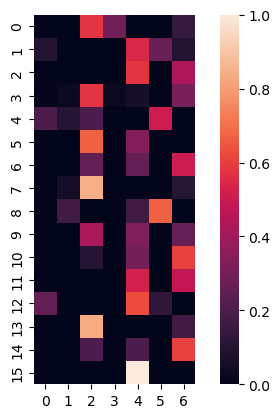

In [266]:
sns.heatmap(match_matrix2/np.sum(match_matrix2,axis=1)[:,np.newaxis],square=True)

In [17]:
def compute_modularity(adj_matrix, labels):
    total_edges = adj_matrix[adj_matrix>0].sum()
    m = total_edges / 2
    q = 0
    degree_row = []
    degree_col = []
    for i in range(adj_matrix.shape[0]):
        degree_row.append(np.nonzero(adj_matrix[i,:]).sum())
    for i in range(adj_matrix.shape[1]):
        degree_col.append(np.nonzero(adj_matrix[:,i]).sum())

    for i in range(adj_matrix.shape[0]):
        for j in range(adj_matrix.shape[1]):
            if labels[i] == labels[j]:      
                q += (adj_matrix[i,j]-degree_row[i]*degree_col[j]/(2*m))
    
    return q / (2*m)